In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Imports and Paths
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

image_path = "/content/drive/My Drive/oil_spill_project/train/images/Oil (1035).jpg"
mask_path = image_path.replace("images", "masks").replace(".jpg", ".png")


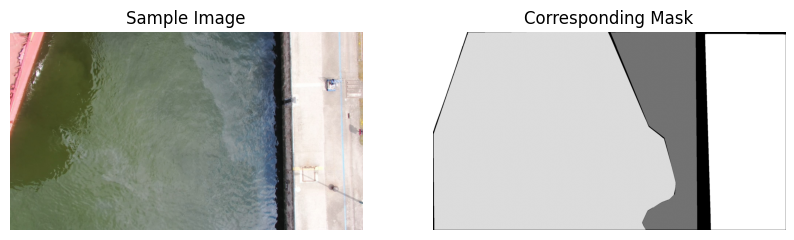

In [4]:
#load one sample image and its mask
image_pil = tf.keras.utils.load_img(image_path)
mask_pil  = tf.keras.utils.load_img(mask_path, color_mode="grayscale")

image = tf.keras.utils.img_to_array(image_pil) / 255.0
mask  = tf.keras.utils.img_to_array(mask_pil) / 255.0

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Sample Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask[:,:,0], cmap="gray")
plt.title("Corresponding Mask")
plt.axis("off")
plt.show()



In [5]:
#quality check step before preprocessing and training
mask_np = np.array(mask_pil)

print("Image size:", image_pil.size, "mode:", image_pil.mode)
print("Mask size:", mask_pil.size, "mode:", mask_pil.mode)
print("Mask unique values:", np.unique(mask_np))


Image size: (1920, 1080) mode: RGB
Mask size: (1920, 1080) mode: L
Mask unique values: [  0  90 174 202]


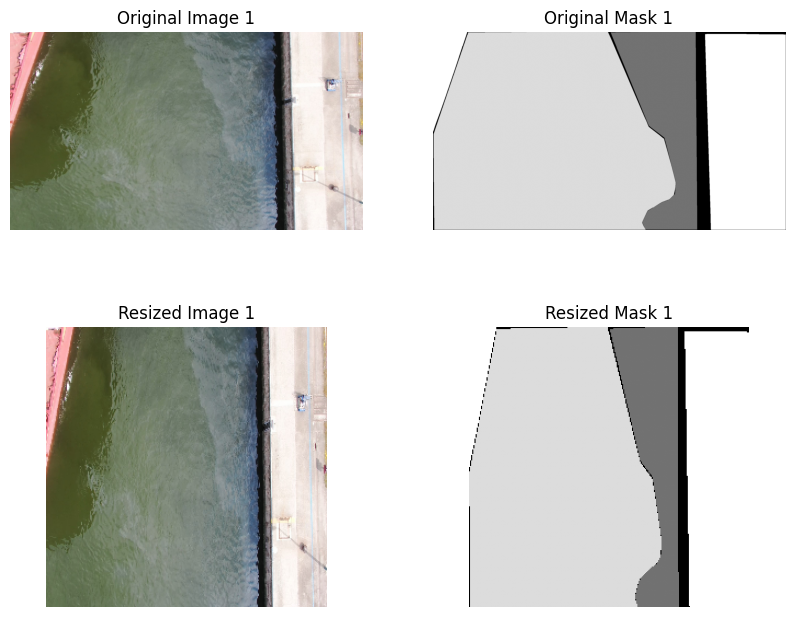

Example 1:
Resized Image: (256, 256, 3) <dtype: 'float32'>
Resized Mask: (256, 256) <dtype: 'int32'> Unique labels: [  0  90 174 202]


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Resize Functions
IMG_SIZE = (256, 256)

def resize_image(img):
    return tf.image.resize(img, IMG_SIZE) / 255.0

def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.expand_dims(mask, axis=0)
    mask = tf.image.resize(mask, IMG_SIZE, method="nearest")
    mask = tf.squeeze(mask, axis=0)

    if mask.shape[-1] == 3:
        mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.squeeze(mask, axis=-1)
    return tf.cast(mask, tf.int32)

# Example images and masks (replace with your own PIL images)
examples = [
    (image_pil, mask_pil),
]

for i, (img_pil, mask_pil) in enumerate(examples):
    # Convert to tensors
    img_tf  = tf.convert_to_tensor(np.array(img_pil), dtype=tf.float32)
    mask_tf = tf.convert_to_tensor(np.array(mask_pil), dtype=tf.float32)

    # Resize
    img_resized  = resize_image(img_tf)
    mask_resized = resize_mask(mask_tf)

    # Plot original and resized
    plt.figure(figsize=(10, 8)) # Adjusted figure size for two rows

    plt.subplot(2, 2, 1) # First row, first column
    plt.imshow(img_tf / 255.0)
    plt.title(f"Original Image {i+1}")
    plt.axis("off")

    plt.subplot(2, 2, 2) # First row, second column
    plt.imshow(mask_tf, cmap="gray")
    plt.title(f"Original Mask {i+1}")
    plt.axis("off")

    plt.subplot(2, 2, 3) # Second row, first column
    plt.imshow(img_resized)
    plt.title(f"Resized Image {i+1}")
    plt.axis("off")

    plt.subplot(2, 2, 4) # Second row, second column
    plt.imshow(mask_resized, cmap="gray")
    plt.title(f"Resized Mask {i+1}")
    plt.axis("off")

    plt.show()

    print(f"Example {i+1}:")
    print("Resized Image:", img_resized.shape, img_resized.dtype)
    print("Resized Mask:", mask_resized.shape, mask_resized.dtype,
          "Unique labels:", np.unique(mask_resized.numpy()))

Spill region: mean = 0.5296268 std = 0.21469107
Background: mean = 0.25465316 std = 0.23931256


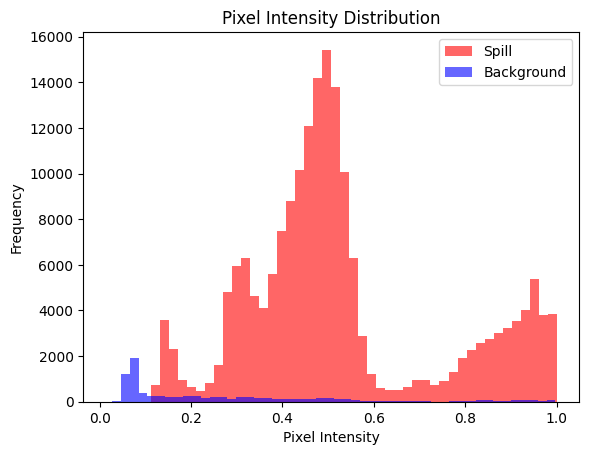

In [7]:
#Statistical Properties (Spill vs Non-Spill)
mask_binary = tf.cast(mask_resized > 0, tf.bool)

spill_pixels = tf.boolean_mask(img_resized, mask_binary)
bg_pixels    = tf.boolean_mask(img_resized, ~mask_binary)

print("Spill region: mean =", tf.reduce_mean(spill_pixels).numpy(),
      "std =", tf.math.reduce_std(spill_pixels).numpy())
print("Background: mean =", tf.reduce_mean(bg_pixels).numpy(),
      "std =", tf.math.reduce_std(bg_pixels).numpy())

plt.hist(tf.reshape(spill_pixels, [-1]).numpy(), bins=50, color="red", alpha=0.6, label="Spill")
plt.hist(tf.reshape(bg_pixels, [-1]).numpy(),   bins=50, color="blue", alpha=0.6, label="Background")
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


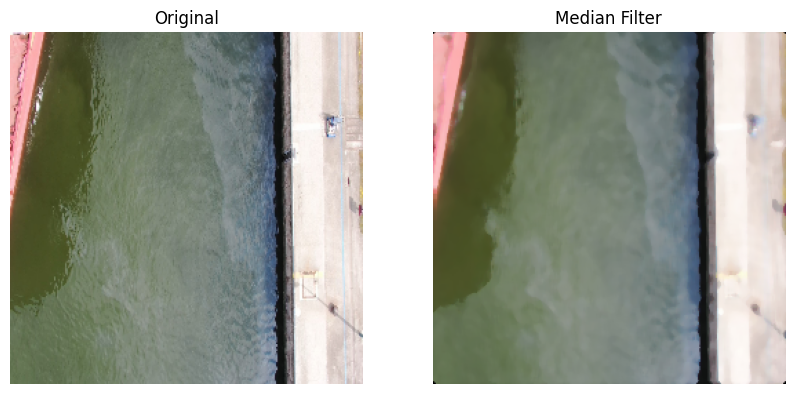

In [8]:
#general denoising
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def median_filter(img, ksize=5):
    img_with_batch = tf.expand_dims(img, 0)

    patches = tf.image.extract_patches(
        images=img_with_batch,
        sizes=[1, ksize, ksize, 1],
        strides=[1, 1, 1, 1],
        rates=[1, 1, 1, 1],
        padding="SAME"
    )
    patches_reshaped = tf.reshape(patches, [tf.shape(patches)[0], tf.shape(patches)[1], tf.shape(patches)[2], ksize*ksize, tf.shape(img)[-1]])
    median = tf.sort(patches_reshaped, axis=-2)[..., ksize*ksize // 2, :]
    return tf.squeeze(median, 0)
filtered_img = median_filter(img_resized, ksize=5)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_resized.numpy())
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)

plt.imshow(filtered_img.numpy())
plt.title("Median Filter")
plt.axis("off")
plt.show()

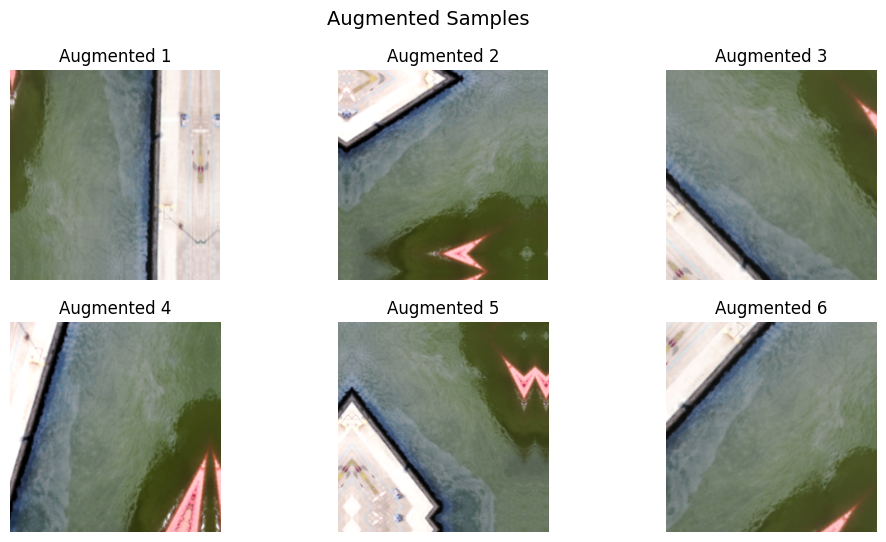

In [9]:
#Augmentation Pipeline
img_tf = tf.expand_dims(img_resized, axis=0)

class SafeAugment(tf.keras.Sequential):
    def call(self, inputs, training=None):
        x = super().call(inputs, training=training)
        return tf.clip_by_value(x, 0.0, 1.0)

augment = SafeAugment([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomZoom(0.2),
])

plt.figure(figsize=(12,6))
for i in range(6):
    aug_img = augment(img_tf, training=True)[0]
    plt.subplot(2,3,i+1)
    plt.imshow(aug_img.numpy())
    plt.axis("off")
    plt.title(f"Augmented {i+1}")

plt.suptitle("Augmented Samples", fontsize=14)
plt.show()


In [10]:
#Final Normalization
mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
std  = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

img_normalized = (img_resized - mean) / std

print("Final normalized image:", img_normalized.shape,
      "min =", tf.reduce_min(img_normalized).numpy(),
      "max =", tf.reduce_max(img_normalized).numpy())




Final normalized image: (256, 256, 3) min = -2.0587032 max = 2.64


In [11]:
import os
import numpy as np
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array


IMAGE_DIR = "/content/drive/My Drive/oil_spill_project/train/images/"
MASK_DIR  = "/content/drive/My Drive/oil_spill_project/train/masks/"

IMG_HEIGHT, IMG_WIDTH = 128, 128
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)

def load_dataset(image_dir, mask_dir):
    images = sorted(glob(os.path.join(image_dir, "*.jpg")))
    masks  = sorted(glob(os.path.join(mask_dir, "*.png")))

    X, Y = [], []
    for img_path, mask_path in zip(images, masks):

        img  = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
        mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")

        img  = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0


        mask = (mask > 0.5).astype(np.float32)

        X.append(img)
        Y.append(mask)

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)


X, Y = load_dataset(IMAGE_DIR, MASK_DIR)

print("Images:", X.shape, "Masks:", Y.shape)


Images: (811, 128, 128, 1) Masks: (811, 128, 128, 1)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Train set:", X_train.shape, Y_train.shape)
print("Val set:", X_val.shape, Y_val.shape)

Train set: (648, 128, 128, 1) (648, 128, 128, 1)
Val set: (163, 128, 128, 1) (163, 128, 128, 1)


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

def conv_block(x, filters, kernel_size=3, activation='relu', padding='same'):
    x = layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)(x)
    x = layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(128,128,1), num_classes=1, base_filters=16):
    inputs = layers.Input(shape=input_shape)

    c1, p1 = encoder_block(inputs, base_filters)
    c2, p2 = encoder_block(p1, base_filters*2)
    c3, p3 = encoder_block(p2, base_filters*4)
    c4, p4 = encoder_block(p3, base_filters*8)

    b = conv_block(p4, base_filters*16)

    d4 = decoder_block(b, c4, base_filters*8)
    d3 = decoder_block(d4, c3, base_filters*4)
    d2 = decoder_block(d3, c2, base_filters*2)
    d1 = decoder_block(d2, c1, base_filters)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid', dtype='float32')(d1)

    model = models.Model(inputs, outputs)
    return model

unet = build_unet(input_shape=INPUT_SHAPE)
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
import tensorflow.keras.backend as K

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [15]:
unet.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy", iou_metric, dice_coefficient])
history = unet.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=50
)



Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - accuracy: 0.6363 - dice_coefficient: 0.6265 - iou_metric: 0.4589 - loss: 0.6495 - val_accuracy: 0.6255 - val_dice_coefficient: 0.6824 - val_iou_metric: 0.5190 - val_loss: 0.6041
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6397 - dice_coefficient: 0.6583 - iou_metric: 0.4944 - loss: 0.5972 - val_accuracy: 0.6809 - val_dice_coefficient: 0.7490 - val_iou_metric: 0.6002 - val_loss: 0.5490
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7499 - dice_coefficient: 0.7470 - iou_metric: 0.5998 - loss: 0.4862 - val_accuracy: 0.7906 - val_dice_coefficient: 0.7554 - val_iou_metric: 0.6094 - val_loss: 0.4246
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7982 - dice_coefficient: 0.7625 - iou_metric: 0.6190 - loss: 0.4441 - val_accuracy: 0.8348 - val_dice_coefficient: 0.8220 - val_iou_metric: 0.6995 - val_loss: 0.3712
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8368 - dic

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


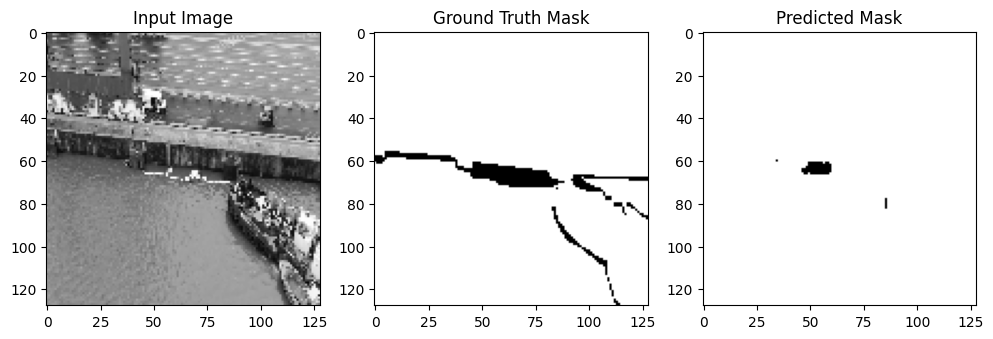

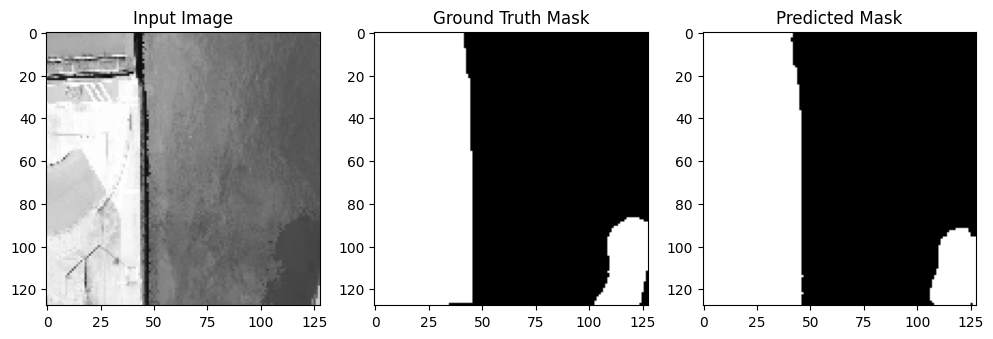

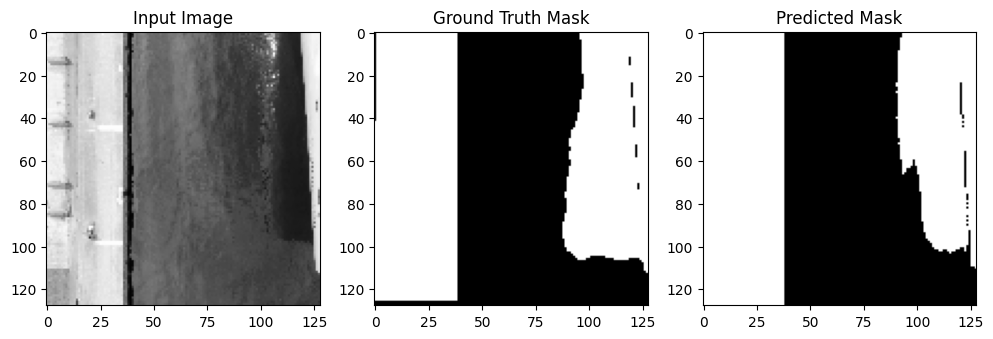

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(model, X_val, Y_val, num_samples=3):
    idx = np.random.choice(len(X_val), num_samples, replace=False)
    preds = model.predict(X_val[idx])

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(X_val[idx][i].squeeze(), cmap="gray")
        plt.title("Input Image")

        # Ground Truth
        plt.subplot(1, 3, 2)
        plt.imshow(Y_val[idx][i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow((preds[i] > 0.5).squeeze().astype(np.float32), cmap="gray")
        plt.title("Predicted Mask")

        plt.show()

# Select a fixed random subset for visualization
num_samples_to_visualize = 3
visualize_indices = np.random.choice(len(X_val), num_samples_to_visualize, replace=False)

# Predict on the selected subset once
visualize_preds = unet.predict(X_val[visualize_indices])

# Visualize the results from the fixed subset
for i in range(num_samples_to_visualize):
    plt.figure(figsize=(12, 4))

    # Input Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[visualize_indices][i].squeeze(), cmap="gray")
    plt.title("Input Image")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(Y_val[visualize_indices][i].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow((visualize_preds[i] > 0.5).squeeze().astype(np.float32), cmap="gray")
    plt.title("Predicted Mask")

    plt.show()

In [17]:
from tensorflow.keras.metrics import Precision, Recall

# Recompile the model with Precision and Recall metrics
unet.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy", iou_metric, dice_coefficient, Precision(), Recall()])

print("Model recompiled with Precision and Recall metrics.")

Model recompiled with Precision and Recall metrics.


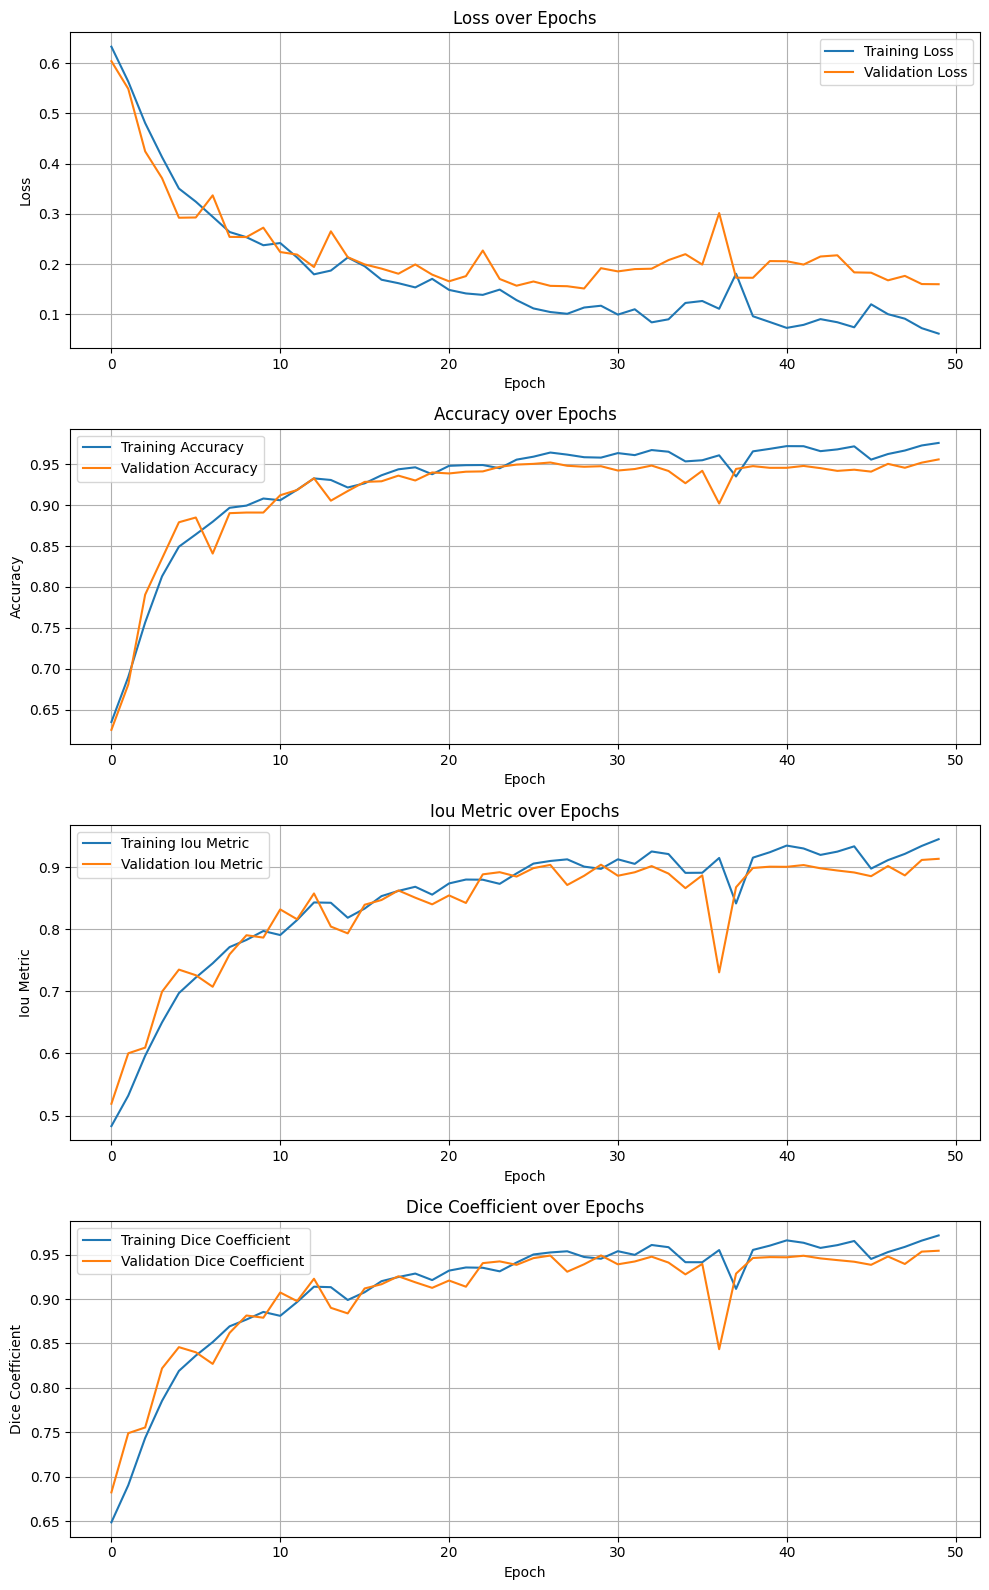

In [18]:
# Plot training history
metrics_to_plot = ['loss', 'accuracy', 'iou_metric', 'dice_coefficient']
if 'precision' in history.history:
    metrics_to_plot.append('precision')
if 'recall' in history.history:
    metrics_to_plot.append('recall')

num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(10, num_metrics * 4))

if num_metrics == 1:
    axes = [axes] # Ensure axes is an iterable

for i, metric in enumerate(metrics_to_plot):
    axes[i].plot(history.history[metric], label=f'Training {metric.replace("_", " ").title()}')
    if f'val_{metric}' in history.history:
        axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric.replace("_", " ").title()}')
    axes[i].set_title(f'{metric.replace("_", " ").title()} over Epochs')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(metric.replace("_", " ").title())
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [19]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.0 MB/s eta 0:00:00


In [38]:
import keras_tuner as kt

def build_hypermodel(hp):
    """Builds a Keras model with hyperparameters to tune."""
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

    # Hyperparameters to tune
    base_filters = hp.Choice('base_filters', values=[16, 32, 64])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)

    x = inputs

    # Encoder
    c1, p1 = encoder_block(x, base_filters)
    c2, p2 = encoder_block(p1, base_filters * 2)
    c3, p3 = encoder_block(p2, base_filters * 4)
    c4, p4 = encoder_block(p3, base_filters * 8)

    # Bottleneck with dropout
    b = conv_block(p4, base_filters * 16)
    b = layers.Dropout(dropout_rate)(b)

    # Decoder
    d4 = decoder_block(b, c4, base_filters * 8)
    d3 = decoder_block(d4, c3, base_filters * 4)
    d2 = decoder_block(d3, c2, base_filters * 2)
    d1 = decoder_block(d2, c1, base_filters)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', dtype='float32')(d1)

    model = tf.keras.models.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="binary_crossentropy",
                  metrics=["accuracy", iou_metric, dice_coefficient])

    return model

In [40]:
# Set up the tuner
tuner = kt.Hyperband(
    build_hypermodel,
    objective=kt.Objective("val_iou_metric", direction="max"),
    max_epochs=20,
    factor=3,
    directory='oil_spill_tuning',
    project_name='unet_hyperband'
)

# Start the hyperparameter search
tuner.search(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of base filters is {best_hps.get('base_filters')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
""")

Trial 30 Complete [00h 02m 01s]
val_iou_metric: 0.8775685429573059

Best val_iou_metric So Far: 0.8775685429573059
Total elapsed time: 00h 51m 27s

The optimal number of base filters is 32.
The optimal learning rate is 0.0005.
The optimal dropout rate is 0.30000000000000004.



In [41]:
# Build the best model and train it
best_model = tuner.get_best_models(num_models=1)[0]

history_tuned = best_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=50  # You can train for more epochs now with the best hyperparameters
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9035 - dice_coefficient: 0.8824 - iou_metric: 0.7915 - loss: 0.2575 - val_accuracy: 0.9263 - val_dice_coefficient: 0.9253 - val_iou_metric: 0.8620 - val_loss: 0.2018
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9201 - dice_coefficient: 0.9025 - iou_metric: 0.8250 - loss: 0.2113 - val_accuracy: 0.8860 - val_dice_coefficient: 0.8664 - val_iou_metric: 0.7672 - val_loss: 0.2891
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9116 - dice_coefficient: 0.8861 - iou_metric: 0.7999 - loss: 0.2266 - val_accuracy: 0.9254 - val_dice_coefficient: 0.9273 - val_iou_metric: 0.8670 - val_loss: 0.2189
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9309 - dice_coefficient: 0.9153 - iou_metric: 0.8453 - loss: 0.1842 - val_accuracy: 0.9374 - val_dice_coefficient: 0.9248 - val_iou_metric: 0.8617 - val_loss: 0.1841
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9459 - dic